# Tugas Eksplorasi Pemrograman 2
Mata Kuliah: Perolehan Informasi

Author: Gibran Brahmanta P., Machffud Tra Harana V.

Dalam tugas ini, anda akan mempelajari bagaimana cara untuk mengambil konten dari sebuah *website* atau bisa disebut juga sebagai *web scraping*.

Notebook ini terdiri dari 2 bagian. Pertama, anda akan diberikan beberapa contoh dasar untuk melakukan *web scraping*. Pada bagian kedua, anda akan diminta untuk menulis *code* untuk melakukan *scraping* pada suatu website secara menyeluruh

Selamat mengerjakan dan semoga bermanfaat!

In [1]:
# !pip install requests

In [2]:
import pandas as pd
import re
import requests

from bs4 import BeautifulSoup

# Bagian 1: Contoh Web Scraping

Contoh untuk mengambil judul, konten, dan seluruh link yang ada pada website [scele.cs.ui.ac.id ](https://scele.cs.ui.ac.id)



In [3]:
def getHTMLdocument(url):
    # request for HTML document of given url
    response = requests.get(url)
    # response will be provided in JSON format
    return response.text

# assign URL
url_to_scrape = "https://scele.cs.ui.ac.id/"

# create document
html_document = getHTMLdocument(url_to_scrape)
soup = BeautifulSoup(html_document, 'html.parser')

print("Title dari url = ", url_to_scrape)
print(soup.title.get_text())
print(10*'===========')

contents = soup.findAll('p')
print("Content dalam url = ", url_to_scrape)
for content in contents:
  print(content)
print(10*'===========')
href_tags = soup.find_all(href=True)
print("Kumpulan semua link dalam url = ", url_to_scrape)
urls = list(set([tag['href'] for tag in href_tags]))
counter = 1
for link in urls:
    if len(link)>=4 and link[:4]=='http':
        print(counter, link, sep=". ")
        counter+=1


Title dari url =  https://scele.cs.ui.ac.id/
SCELE Fakultas Ilmu Komputer Universitas Indonesia
Content dalam url =  https://scele.cs.ui.ac.id/
<p>Salam Mahasiswa,</p>
<p>Seperti yang sudah diumumkan sebelumnya, Fasilkom akan mengadakan kegiatan pelatihan ad hoc yang ditujukan untuk mahasiswa yang akan mengikuti perlombaan di masa mendatang.</p>
<p>Kegiatan pelatihan ad hoc ini akan dilaksanakan setiap hari Jumat Sore <strong>Pukul 13:30 – 16:00</strong>, selama bulan November dan Desember 2023. <strong>Lokasinya di Ruang 2404, Gedung B, Gedung Lama Fasilkom UI</strong>.</p>
<p>PS: Akan disediakan <strong>makan siang</strong> mulai dari <strong>Pukul 12.30 WIB</strong>.</p>
<p>Daftar peserta terpilih dapat dilihat pada link di bawah:</p>
<p><a href="https://univindonesia-my.sharepoint.com/:x:/g/personal/alfan_office_ui_ac_id/EZBcSr7GYrZHn12Ddfes9PcBXtp5hJyXrRkDhRtfHfKN-w?e=ixPZSw"><strong>DAFTAR PESERTA</strong></a></p>
<p>--</p>
<p>Tim Kemahasiswaan</p>
<p>Sehubungan dengan perkuliaha

# Bagian 2: Web Crawling

Pada bagian ini, anda diminta untuk mengimplementasikan beberapa class yang dapat digunakan untuk melakukan web crawling. Website yang dgiunakan dalam bagian ini adalah website resmi [Fasilkom UI](https://cs.ui.ac.id/). Proses web crawling dimulai dengan melakukan scraping pada halaman awal website tersebut, lalu dicari halaman-halaman lain yang terhubung dengan halaman awal. Untuk setiap halaman-halaman lain yang dirujuk, juga dicari halaman-halamain lain yang terhubung dengan halaman tersebut dan seterusnya hingga seluruh halaman yang ada di website resmi Fasilkom UI telah didapatkan kontennya. Perlu dicatat, apabila terdapat suatu halaman yang merujuk ke halaman lain di luar website resmi Fasilkom UI, maka halaman yang dirujuk tidak perlu diambil kontennya. Hasil akhir dari web crawling adalah sebuah tabel berisi halaman apa saja yang ada dalam website tersebut beserta konten dan judul halamannya

Dalam mempercepat waktu pengerjaan, proses scraping dibatasi hingga tingkat kedalaman sebanyak 3 tingkat. Tingkat kedalaman ditentukan dari nilai attribut  'max_depth' pada class WebScraper. Contoh ilustrasi terhadap mekanisme depth pada konteks web crawling dapat dilihat pada tautan [berikut](https://drive.google.com/file/d/1Nk1lHBDiMnC8jhqTiiM0cpbLJQOg-rAO/view?usp=sharing).

Dalam mengimplementasikan web crawling, anda perlu menerapkan beberapa hal berikut





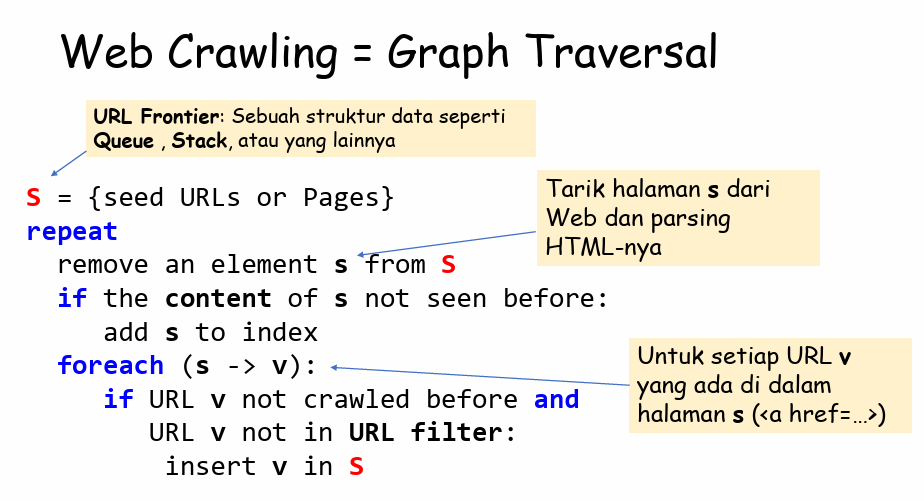

1. Menerapkan skema algoritma seperti pada gambar di atas.(dalam hal ini, anda dapat mengasumsikan bahwa setiap pasangan url yang berbeda akan memiliki hasil fetch dokumen yang berbeda juga)
2. Menggunakan konsep URL Frontier yang memanfaatkan persistent queue.
3. Mengecek URL filter yang akan di-crawl sedemikian memiliki kesesuaian dengan robots.txt [https://cs.ui.ac.id/robots.txt] (diizinkan berdasarkan robots.txt) atau tidak
4. Menyimpan checksum url dengan rabin's signature


In [4]:
from bs4 import BeautifulSoup
from multiprocessing.dummy import Pool

import _thread
import binascii
import glob
import marshal
import os
import rabin
import requests
import re
import shutil
import sys
import urllib.robotparser

In [5]:
INDEX_FILENAME = 'index'

# Exception thrown when calling get() on an empty queue
class Empty(Exception):  pass

class PersistentQueue:

    def __init__(self, name, cache_size=512, marshal=marshal):
        """
        Create a persistent FIFO queue named by the 'name' argument.

        The number of cached queue items at the head and tail of the queue
        is determined by the optional 'cache_size' parameter.  By default
        the marshal module is used to (de)serialize queue items, but you
        may specify an alternative serialize module/instance with the
        optional 'marshal' argument (e.g. pickle).
        """
        assert cache_size > 0, 'Cache size must be larger than 0'
        self.name = name
        self.cache_size = cache_size
        self.marshal = marshal
        self.index_file = os.path.join(name, INDEX_FILENAME)
        self.temp_file = os.path.join(name, 'tempfile')
        self.mutex = _thread.allocate_lock()
        self._init_index()

    def _init_index(self):
        if not os.path.exists(self.name):
            os.mkdir(self.name)
        if os.path.exists(self.index_file):
            index_file = open(self.index_file)
            self.head, self.tail = map(lambda x: int(x),
                                       index_file.read().split(' '))
            index_file.close()
        else:
            self.head, self.tail = 0, 1
        def _load_cache(cache, num):
            name = os.path.join(self.name, str(num))
            mode = 'rb+' if os.path.exists(name) else 'wb+'
            cachefile = open(name, mode)
            try:
                setattr(self, cache, self.marshal.load(cachefile))
            except EOFError:
                setattr(self, cache, [])
            cachefile.close()
        _load_cache('put_cache', self.tail)
        _load_cache('get_cache', self.head)
        assert self.head < self.tail, 'Head not less than tail'

    def _sync_index(self):
        assert self.head < self.tail, 'Head not less than tail'
        index_file = open(self.temp_file, 'w')
        index_file.write('%d %d' % (self.head, self.tail))
        index_file.close()
        if os.path.exists(self.index_file):
            os.remove(self.index_file)
        os.rename(self.temp_file, self.index_file)

    def _split(self):
        put_file = os.path.join(self.name, str(self.tail))
        temp_file = open(self.temp_file, 'wb')
        self.marshal.dump(self.put_cache, temp_file)
        temp_file.close()
        if os.path.exists(put_file):
            os.remove(put_file)
        os.rename(self.temp_file, put_file)
        self.tail += 1
        if len(self.put_cache) <= self.cache_size:
            self.put_cache = []
        else:
            self.put_cache = self.put_cache[:self.cache_size]
        self._sync_index()

    def _join(self):
        current = self.head + 1
        if current == self.tail:
            self.get_cache = self.put_cache
            self.put_cache = []
        else:
            get_file = open(os.path.join(self.name, str(current)), 'rb')
            self.get_cache = self.marshal.load(get_file)
            get_file.close()
            try:
                os.remove(os.path.join(self.name, str(self.head)))
            except:
                pass
            self.head = current
        if self.head == self.tail:
            self.head = self.tail - 1
        self._sync_index()

    def _sync(self):
        self._sync_index()
        get_file = os.path.join(self.name, str(self.head))
        temp_file = open(self.temp_file, 'wb')
        self.marshal.dump(self.get_cache, temp_file)
        temp_file.close()
        if os.path.exists(get_file):
            os.remove(get_file)
        os.rename(self.temp_file, get_file)
        put_file = os.path.join(self.name, str(self.tail))
        temp_file = open(self.temp_file, 'wb')
        self.marshal.dump(self.put_cache, temp_file)
        temp_file.close()
        if os.path.exists(put_file):
            os.remove(put_file)
        os.rename(self.temp_file, put_file)

    def __len__(self):
        """
        Return number of items in queue.
        """
        self.mutex.acquire()
        try:
            return (((self.tail-self.head)-1)*self.cache_size) + \
                    len(self.put_cache) + len(self.get_cache)
        finally:
            self.mutex.release()

    def sync(self):
        """
        Synchronize memory caches to disk.
        """
        self.mutex.acquire()
        try:
            self._sync()
        finally:
            self.mutex.release()

    def put(self, obj):
        """
        Put the item 'obj' on the queue.
        """
        self.mutex.acquire()
        try:
            self.put_cache.append(obj)
            if len(self.put_cache) >= self.cache_size:
                self._split()
        finally:
            self.mutex.release()

    def get(self):
        """
        Get an item from the queue.
        Throws Empty exception if the queue is empty.
        """
        self.mutex.acquire()
        try:
            if len(self.get_cache) > 0:
                return self.get_cache.pop(0)
            else:
                self._join()
                if len(self.get_cache) > 0:
                    return self.get_cache.pop(0)
                else:
                    raise Empty
        finally:
            self.mutex.release()

    def close(self):
        """
        Close the queue.  Implicitly synchronizes memory caches to disk.
        No further accesses should be made through this queue instance.
        """
        self.mutex.acquire()
        try:
            self._sync()
            if os.path.exists(self.temp_file):
                try:
                    os.remove(self.temp_file)
                except:
                    pass
        finally:
            self.mutex.release()

In [6]:
from requests.exceptions import HTTPError


class Node:

    def __init__(self, url_link, pattern) -> None:
        self.url_link = url_link
        self.pattern = pattern
        self.soup = None
        self.create_info()

    def create_info(self) -> None:
        html_doc = self.get_html_doc(self.url_link)
        self.soup = BeautifulSoup(html_doc, 'html.parser')
        self.title = self.get_title()
        self.content = self.get_content()

    def get_html_doc(self, url_link) -> str:
        try:
            response = requests.get(url_link, verify=False)
            response.raise_for_status()  # will raise an HTTPError for bad responses
            return response.text
        except HTTPError as http_err:
            print(f"HTTP error occurred: {http_err}")  # Python 3.6+
            # Alternatively, you could log the error to a file or logging system
        except Exception as err:
            print(f"An error occurred: {err}")  # Python 3.6+
        return ""

    def get_title(self) -> str:
        """
        Implementasikan fungsi untuk mengambil judul dari sebuah halaman
        """
        if self.soup and self.soup.title:
            return self.soup.title.string.strip()
        else:
            return "No Title Found"

    def get_content(self) -> str:
        """
        Implementasikan fungsi untuk mengambil konten dari sebuah halaman.
        Pastikan konten yang diambil sudah bersih dari tag-tag HTML.
        """
        # Menghilangkan script dan style dari dokumen HTML
        for script_or_style in self.soup(["script", "style"]):
            script_or_style.decompose()

        # Dapatkan teks dan bersihkan dari whitespace berlebih
        text = self.soup.get_text()
        lines = (line.strip() for line in text.splitlines())
        chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
        text_content = '\n'.join(chunk for chunk in chunks if chunk)

        return text_content

    def get_referred_pages(self):
        """
        Implementasikan fungsi untuk mendapatkan semua halaman yang dirujuk
        """
        links = set()  # Using a set to avoid duplicate URLs
        for link in self.soup.find_all('a', href=True):
            href = link['href']
            if re.match(self.pattern, href):  # Check if the link matches the pattern
                links.add(href)
        return list(links)  # Return a list of unique links

In [7]:
# NOTE: Nilai max_depth == -1 artinya proses crawling dilakukan pada seluruh halaman yang ada dalam suatu website.
# Apabila tidak, lakukan crawling pada halaman-halaman yang memiliki kedalaman <= nilai max_depth

import re
import requests
from bs4 import BeautifulSoup
from urllib.robotparser import RobotFileParser
from concurrent.futures import ThreadPoolExecutor
import warnings
from urllib3.exceptions import InsecureRequestWarning

# Suppress only the single InsecureRequestWarning from urllib3 needed
warnings.filterwarnings('ignore', category=InsecureRequestWarning)

class WebScraper:

    def __init__(self, start_url, max_depth=-1, user_agent="TEP") -> None:
        self.start_url = start_url
        self.pattern = "http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+" # regex untuk URL
        self.max_depth = max(max_depth, -1)
        self.user_agent = user_agent
        self.is_visited = set()
        self.robot_parser = RobotFileParser()
        self.init_robot_parser()

    def init_robot_parser(self) -> None:
                """
                Initialize a robot file parser and parse the robots.txt.
                """
                self.robot_parser.set_url(f"{self.start_url}robots.txt")
                print(f"Reading robots.txt from {self.start_url}/robots.txt")
                self.robot_parser.read()

    def scrape(self) -> list[Node]:
        """
        Implementasikan suatu fungsi untuk melakukan web crawling sesuai ketentuan soal
        """
        queue = PersistentQueue('queue')  # Initialize the queue with a directory called 'queue'
        # queue.put((self.start_url, 0))  # Add the start URL to the queue with depth 0
        # print the entire queue
        print(len(queue))
        # while True:
        #     try:
        #         print(queue.get())
        #     except Empty:
        #         break
        nodes = []  # List to store the nodes created from the crawled URLs

        # while queue:
        #     url, depth = queue.get()  # Get the next URL and its depth
        #     print(f"Scraping {url} at depth {depth}")
        #     if url not in self.is_visited and depth <= self.max_depth:  # Check if we should visit this depth
        #         if self.is_url_valid(url):
        #             node = Node(url, self.pattern)
        #             nodes.append(node)
        #             self.is_visited.add(url)
        # 
        #             if depth < self.max_depth or self.max_depth == -1:  # Only look for child URLs if not at max depth
        #                 child_urls = node.get_referred_pages()  # Assuming this method exists in Node
        #                 for child_url in child_urls:
        #                     if child_url not in self.is_visited and self.is_url_valid(child_url):
        #                         queue.put((child_url, depth + 1))  # Increment depth for child URLs

        return nodes

    def is_url_valid(self, url: str) -> bool:
        """
        Implementasi fungsi yang mengecek apakah suatu URL diperbolehkan untuk dijadikan target scraping.
        """
        return self.robot_parser.can_fetch(self.user_agent, url)


    def fetch_url_contents_parallel(self, urls: list[str], num_processes=2) -> list[BeautifulSoup]:
        """
        Fetch the contents of the URLs in parallel and return a list of BeautifulSoup objects.
        """
        with ThreadPoolExecutor(max_workers=num_processes) as executor:
            soups = list(executor.map(self.create_soup, urls))
        return soups

    def create_soup(self, url_link: str) -> BeautifulSoup:
        """
        Create a BeautifulSoup object from the HTML content of a given URL.
        """
        response = requests.get(url_link, headers={'User-Agent': self.user_agent})
        return BeautifulSoup(response.content, 'html.parser')

    def init_checksum(self) -> tuple[int, int, int]:
        """
        Mengembalikan bilangan n=p*q, p, q di mana p dan q adalah pasangan bilangan prima
        yang di-generate dari module rabin berdasarkan suatu nilai seed.
        """
        # Anda perlu memastikan bahwa seed yang Anda gunakan memenuhi persyaratan dari module rabin.
        seed = b'\x01'
        p, q = rabin.gen_prime_pair(seed)
        n = p * q
        return n, p, q

    def url_to_bytes(self, url: str) -> bytes:
        """
        Convert a URL to bytes.
        """
        return bytes.fromhex(url.encode().hex())


    def get_checksum(self, p: int, q: int, message: str) -> tuple[int, int]:
        """
        Mengembalikan signature dan number of padding bytes.
        """
        # Pertama-tama kita harus mengubah pesan menjadi bytes.
        message_bytes = message.encode('utf-8')

        # Menggunakan module rabin untuk menandatangani pesan.
        signature, padding = rabin.sign_rabin(p, q, message_bytes)

        # Mengembalikan tanda tangan dan jumlah padding.
        return signature, padding

    def reformat_url(self, url_link, level):
        return "{}_{}".format(url_link, level)

    def parse_data(self, data):
        res = data.split("_")
        return res[0], int(res[1])

    def get_child_process(self, lst_child, p, q):
        lst_child_process = []
        for child in lst_child:
            if not child.startswith(self.start_url):
                child = self.start_url[:-1] + child
            if self.is_url_valid(child):
                child_bytes = self.url_to_bytes(child)
                sig, pad = self.get_checksum(p, q, child_bytes)
                if sig not in self.is_visited:
                    lst_child_process.append(child)
                    self.is_visited[sig] = False
        return lst_child_process

In [8]:
shutil.rmtree('scraper', ignore_errors=True)

In [9]:
web = "https://cs.ui.ac.id/"
max_depth = 3

scraper = WebScraper(web, max_depth)

result = scraper.scrape()
# Sanity Test
list_url_link = []
for node in result:
    list_url_link.append(node.url_link)
len(set(list_url_link)) == len(list_url_link)# Expected: True

Reading robots.txt from https://cs.ui.ac.id//robots.txt
512


True

In [10]:
# Save data into DataFrame

def save_data_into_dataframe(lst_node) -> pd.DataFrame():
    """
    TO DO: Implementasikan suatu fungsi untuk menyimpan data-data dari setiap halaman yang didapat ke suatu DataFrame
    """
    return pd.DataFrame()

name = "" #TO DO: Isi nama
npm = "" #TO DO: Isi NPM

df_result = save_data_into_dataframe(result)
df_result.to_csv("./{}_{}.csv".format(name, npm), index=False)

df_result

""
